In [4]:
#%pip install lenskit
#%pip install tbb

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\perni\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


   user  item  rating
0     0     0       1
1     1     1       1
2     2     1       1
3     3     1       1
4     4     1       1
****** START TRAINING ********
ALS
ALS_Implicit
ALS_Implicit_weight
Popular
ALS
ALS_Implicit
ALS_Implicit_weight
Popular
ALS
ALS_Implicit
ALS_Implicit_weight
Popular
ALS
ALS_Implicit
ALS_Implicit_weight
Popular
ALS
ALS_Implicit
ALS_Implicit_weight
Popular
****** DONE TRAINING ********
******** ALL RECS ********
   item     score  user  rank Algorithm
0   886  2.715157     2     1       ALS
1  2317  2.472537     2     2       ALS
2  2893  2.418646     2     3       ALS
3  2906  2.378837     2     4       ALS
4  1111  2.332829     2     5       ALS
[1, 0, 0, 0, 1, 1, 1, 0, 0, 0] 4365
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 4365
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 4365
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 4365
********* RESULTS **********
                nrecs  ndcg_10  precision_10  recall_10
Algorithm user                                         
ALS       2        10      0.0

fitting an Implicit ALS model with ratings and default settings
in LensKit 0.14, the default behavior for this scenario will change
explicitly specify the use_ratings option for consistent behavior
see http://bit.ly/lkpy-imf for details
C:\Users\perni\AppData\Local\Programs\Python\Python39\lib\site-packages\lenskit\algorithms\als.py:667: UserWarning: Fitting Implicit ALS with ratings and defaults; the default behavior in this
scenario will change in LensKit 0.14. Specify the use_ratings option to
ImplicitMF to get consistent behavior in the future. See the documentation
at http://bit.ly/lkpy-imf for more details.
  warnings.warn(util.clean_str('''
fitting an Implicit ALS model with ratings and default settings
in LensKit 0.14, the default behavior for this scenario will change
explicitly specify the use_ratings option for consistent behavior
see http://bit.ly/lkpy-imf for details
fitting an Implicit ALS model with ratings and default settings
in LensKit 0.14, the default behavior for t

NameError: name 'lmbdas' is not defined

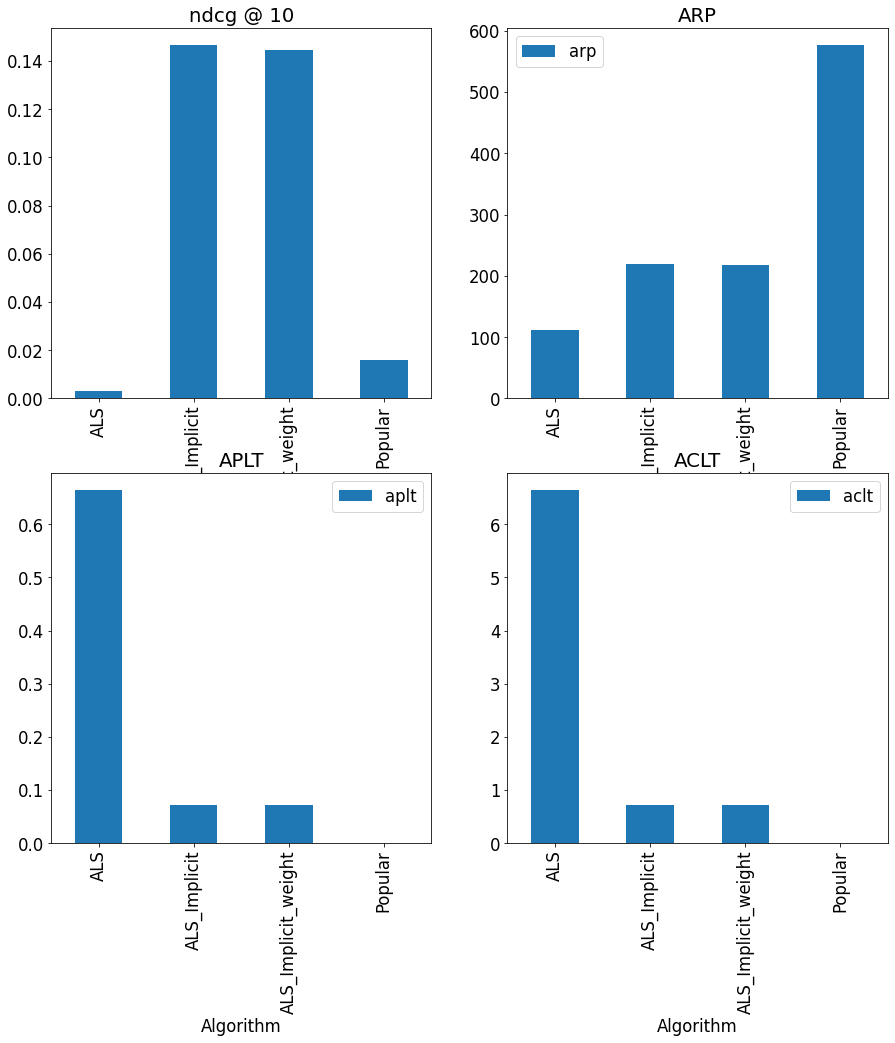

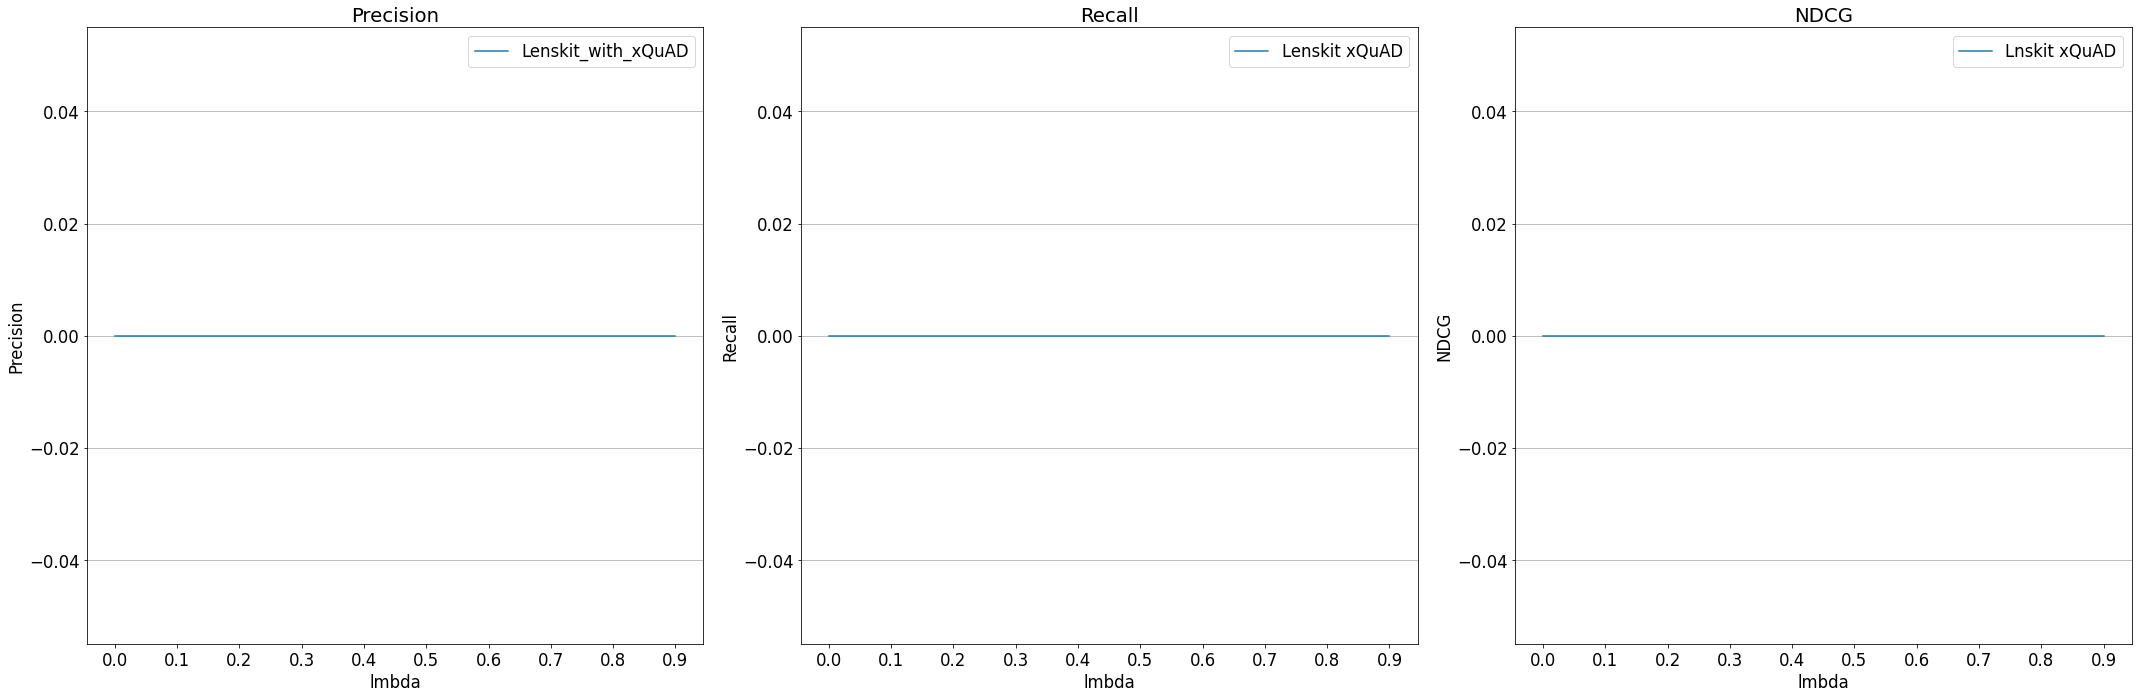

<Figure size 2160x540 with 0 Axes>

In [7]:
import os
from lenskit import batch, topn, util
from lenskit.metrics.topn import bulk_impl
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, basic, als, item_knn as knn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data import get_rating_matrix, get_interactions, get_job_data, get_job_interactions_matrix
from metrices import ARP, APLT, ACLT
from xQuAD.xQuAD import RankerXQuad
from xQuAD.Model import save_obj


def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 10)

    # add the algorithm name for analyzability
    recs['Algorithm'] = aname

    #predict ratings
    print(aname)
    if aname != 'Popular':
        preds = batch.predict(fittable, test)
        preds['Algorithm'] = aname

        return recs, preds

    return recs
#algo_ii = knn.ItemItem(20)
def initaite(ratings):
    algo_als = als.BiasedMF(50)
    algo_als_implicit = als.ImplicitMF(50)
    algo_als_implicit_ratings = als.ImplicitMF(50, use_ratings =True)
    algo_popular = basic.Popular()

    all_recs = []
    all_preds =[]
    test_data = []
    train_data = []
    print('****** START TRAINING ********')
    for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
        test_data.append(test)
        train_data.append(train)

        als_rec, alc_preds = eval('ALS', algo_als, train, test)
        als_implicit_rec, als_implicit_preds = eval('ALS_Implicit', algo_als_implicit, train, test)
        als_implicit_weight_rec, als_implicit_weight_preds = eval('ALS_Implicit_weight', algo_als_implicit_ratings, train, test)
        popular_rec = eval('Popular', algo_popular, train, test)

        all_recs.append(als_rec)
        all_recs.append(als_implicit_rec)
        all_recs.append(als_implicit_weight_rec)
        all_recs.append(popular_rec)

        all_preds.append(alc_preds)
        all_preds.append(als_implicit_preds)
        all_preds.append(als_implicit_weight_preds)

    print('****** DONE TRAINING ********' )
    all_recs = pd.concat(all_recs, ignore_index=True)
    return all_recs, all_preds, test_data, train_data

def main(ratings, long_tail):


    print(ratings.head())
    all_recs, all_preds, test_data, train_data = initaite(ratings)
    print('******** ALL RECS ********')
    print(all_recs.head())
    test_data = pd.concat(test_data, ignore_index=True)
    train_data = pd.concat(train_data, ignore_index=True)

    #print(all_preds.head())

    #rla.add_metric(arp, name='arp_10', train = train_data ,k=10)
    #rla.add_metric(aplt, name='aplt_10', long_tail =long_tail, k=10 )
    pop_results = pd.DataFrame()
    test_users = test_data.user.values
    for algorithm in ['ALS', 'ALS_Implicit', 'ALS_Implicit_weight', 'Popular']:
        recs = all_recs[all_recs.Algorithm == algorithm].rename(columns={'user': 'userId', 'item': 'itemId'})
        arp = ARP(train_items=train_data, test_users=test_users, recommendations=recs, pyspark_ALS=True)
        aplt = APLT(recs, test_users, long_tail, pyspark_ALS=True)
        aclt = ACLT(recs, test_users, long_tail, pyspark_ALS=True)
        pop_results_row = {'Algorithm': algorithm, 'arp': arp, 'aplt': aplt, 'aclt': aclt}
        pop_results = pop_results.append(pop_results_row, ignore_index=True)

    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg, name='ndcg_10', k=10)
    rla.add_metric(topn.precision, name='precision_10', k=10)
    rla.add_metric(topn.recall, name='recall_10', k=10)
    #rla.add_metric(topn.hit, name='hit_10', k=10)

    results = rla.compute(all_recs, test_data)
    print('********* RESULTS **********')
    print(results.head())
    print('mean')
    print(results.groupby('Algorithm').ndcg_10.mean())
    print('precission')
    print(results.groupby('Algorithm').precision_10.mean())
    print('Recall')
    print(results.groupby('Algorithm').recall_10.mean())


    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    results.groupby('Algorithm').ndcg_10.mean().plot(ax= axes[0,0], kind='bar'); axes[0,0].set_title('ndcg @ 10')

    print(pop_results)

    pop_results.plot(ax=axes[0, 1], kind='bar', x= 'Algorithm', y ='arp'); axes[0,1].set_title('ARP')

    pop_results.plot(ax=axes[1,0], kind='bar', x= 'Algorithm', y ='aplt'); axes[1,0].set_title('APLT')

    pop_results.plot(ax=axes[1,1], kind='bar', x= 'Algorithm', y ='aclt'); axes[1,1].set_title('ACLT')
    fig.figure.savefig('./figs/lenskit_results.png')

    #fig_ndcg = results.groupby('Algorithm').ndcg_10.mean().plot(subplots=True).bar()
    # fig_ndcg.savefig('./figs/lenskit_ndcg.png')
    # fig_ndcg.show()
    # fig_ndcg.close()

    # arp_fig = pop_results.groupby('Algorithm').arp.plot.bar()
    # arp_fig.savefig('./figs/lenskit_arp.png')
    # arp_fig.show()
    # arp_fig.close()


    # aplt_fig = pop_results.groupby('Algorithm').aplt.plot.bar()
    # aplt_fig.savefig('./figs/lenskit_aplt.png')
    # aplt_fig.show()
    # aplt_fig.close()

    # aclt_fig = pop_results.groupby('Algorithm').aclt.plot.bar()
    # aclt_fig.savefig('./figs/lenskit_aclt.png')
    # aclt_fig.show()
    # aclt_fig.close()


    return all_recs, train_data, test_data

def rerank(ranking_df, rating_matrix, item_feature_df, train_data, test_data):
    lmbdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #lmbdas = [0.4]
    users = list(np.unique(rating_matrix['user'].values))
    items = list(np.unique(rating_matrix['item'].values))

    predictions = ranking_df.pivot(index='user', columns='item', values = 'score').fillna(0)
    predictions = predictions.reindex(index=users, columns=items, fill_value=0).values

    print(len(predictions), len(users), len(items), len(np.unique(train_data.user)))
    models = {}
    model = RankerXQuad(users = users, items = items, observed_relevance = train_data, unobserved_relevance = test_data, item_field = 'item', rating_field='rating', user_field = 'user', item_feature_df=item_feature_df)

    for lmbda in lmbdas:
        print("Training with ", {'lambda': lmbda})
        model.set_predictions(predictions)
        model.rerank(type='smooth', lmbda=lmbda, k=10, rmax=100)
        scores = model.get_predictions()
        save_obj(scores, os.path.join('./data/outputs/scores/lenskit/reranker-lenskit-' + str(lmbda) + '_scores.pkl'))
        model.test()

        metrics = model.get_metrics()
        save_obj(metrics, os.path.join('./data/outputs/metrics/lenskit/reranker-lenskit-' + str(lmbda) + '_metrics.pkl'))
        model.show_metrics()
        models[lmbda] = model
    return models

def arp(recs, truth, train, k=None):
   if k is not None:
        print('HALLOI')
        recs = recs[recs['rank'] <= k]
        rec_pop = 0
        for user in truth.user.unique():
            theta = 0
            for i in recs[recs['user'] == user].item:
                theta += np.count_nonzero(train.item == i)

            rec_pop += theta / k


        return rec_pop / truth.user.nunique()

@bulk_impl(arp)
def _bulk_arp(recs, truth, train, k=None):
    print('RECS\n', recs)
    print('Truth \n', truth)
    good = recs.join(truth, on=['LKTruthID', 'item'], how='inner')
    if k is not None:
        recs = recs[recs['rank'] <= k]
        rec_pop = 0
        for user in recs.LKTruthID.unique():
            theta = 0
            for i in recs[recs['LKTruthID'] == user].item:
                theta += np.count_nonzero(train.item == i)

            rec_pop += theta / k

    print(rec_pop)
    return rec_pop / recs.LKTruthID.nunique()


def aplt(recs, truth, long_tail,  k=None):
    recs = recs[recs['rank'] <= k]

    for user in recs.LKTruthID.unique():
        rec_long_tail_intersect = len(list(set(recs[recs.LKTruthID == user].items.to_numpy()).intersection(long_tail_items)))
        long_tail +=  rec_long_tail_intersect / k
    return long_tail / recs.LKTruthID.nunique()

@bulk_impl(aplt)
def _bulk_aplt(recs, truth, long_tail,  k=None):
    recs = recs.iloc[:k]

    for user in recs.LKTruthID.unique():
        rec_long_tail_intersect = len(list(set(recommendations[recommendations.userId == user].itemId.to_numpy()).intersection(long_tail_items)))
        rec_list_size  =   recommendations[recommendations.userId == user].shape[0]
        long_tail +=  rec_long_tail_intersect / k

    return long_tail / recs.LKTruthID.nunique()


def aclt(recs, truth, long_tail, k=None):
    recs = recs[recs['rank'] <= k]
    for user in re.user.unique():
        long_tail_score = sum([1 if item in long_tail else 0 for item in recs[recs.user == user]])

    return long_tail_score / truth.users.nunique()

@bulk_impl(aclt)
def _bulk_aclt(recs, truth, k=None):
    recs = recs.iloc[:k]

    long_tail_score = sum([1 if item in long_tail else 0 for item in recs])

    return long_tail_score / truth.users.nunique()

def plot_effectiveness(metrics, lmbdas, k = 0):
    plt.rcParams.update({'font.size': 16.5})
    plt.figure(figsize=(30, 10))

    recalls = {}
    precisions = {}
    ndcgs = {}
    for lmbda in lmbdas:
        precisions[lmbda] = metrics[lmbda]['precision'][0]
        recalls[lmbda] = metrics[lmbda]['recall'][0]
        ndcgs[lmbda ] = metrics[lmbda]['ndcg'][0]

    plt.subplot(131)
    plt.title(r'Precision')
    plt.xlabel('lmbda')
    plt.ylabel('Precision')


    plt.plot(lmbdas, [np.mean(precisions[lmbda]) for lmbda in lmbdas], label="Lenskit_with_xQuAD")
    plt.xticks(lmbdas)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(132)
    plt.title(r'Recall')
    plt.xlabel('lmbda')
    plt.ylabel('Recall')
    plt.plot(lmbdas, [np.mean(recalls[lmbda]) for lmbda in lmbdas], label="Lenskit xQuAD")
    plt.xticks(lmbdas)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(133)
    plt.title(r'NDCG')
    plt.xlabel('lmbda')
    plt.ylabel('NDCG')
    plt.plot(lmbdas,  [np.mean(ndcgs[lmbda])for lmbda in lmbdas], label="Lnskit xQuAD")
    plt.xticks(lmbdas)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()


def plot_item_related_metrics(metrics, lmbda):
    plt.rcParams.update({'font.size': 16.5})
    plt.figure(figsize=(30, 7.5))

    arps = {}
    aplts = {}
    aclts = {}
    for lmbda in lmbdas:
        arps[lmbda] = metrics[lmbda]['ARP'][0]
        aplts[lmbda] = metrics[lmbda]['APLT'][0]
        aclts[lmbda ] = metrics[lmbda]['ACLT'][0]

    plt.subplot(131)
    plt.title(r'Average Recommended Popularity')
    plt.xlabel('lmbda')
    plt.ylabel('ARP')

    plt.plot(lmbdas, [np.mean(arps[lmbda]) for lmbda in lmbdas], label=str())
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(132)
    plt.title(r'Average Percentage of Long Tail')
    plt.xlabel('lmbda')
    plt.ylabel('APLT')

    plt.plot(lmbdas, [np.mean(aplts[lmbda]) for lmbda in lmbdas], label=str())
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(133)
    plt.title(r'Average Coverage of Long Tail')
    plt.xlabel('lmbda')
    plt.ylabel('ACLT')

    plt.plot(lmbdas, [np.mean(aclts[lmbda]) for lmbda in lmbdas], label=str())


    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()


def show_results():
    lmbdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    implicit_metrics = {}
    for lmbda in lmbdas:
        metrics = pd.read_pickle('./data/outputs/metrics/lenskit/reranker-lenskit-' + str(lmbda) + '_metrics.pkl')
        implicit_metrics[lmbda] = metrics


    plot_effectiveness(implicit_metrics, lmbdas)
    plot_item_related_metrics(implicit_metrics, lmbda)

if __name__ == "__main__":
    rating_matrix = pd.read_csv('./data/ratings-filtered-90-days.csv')
    item_feature_df = pd.read_csv('./data/item_feature-filtered-90-days.csv')

    ratings = rating_matrix.rename(columns={'uidx': 'user', 'iidx': 'item'})
    ratings = ratings[['user', 'item', 'rating']]
    recs , train_data, test_data= main(ratings, item_feature_df[item_feature_df.feature == 'long_tail'].iidx.values)


    models = rerank(recs[recs.Algorithm == 'ALS_Implicit'], ratings,  item_feature_df, train_data, test_data)

    show_results()



# %%